<a href="https://colab.research.google.com/github/JuanParias29/BigDataProcessingProject/blob/main/Machine_Learning_ICFES.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Proyecto de Procesamiento de Datos a Gran Escala

El siguiente proyecto analítico basado en la metodología CRISP-DM para el procesamiento de datos de gran escala, orientado a resolver preguntas de negocio en entornos educativos utilizando herramientas de Big Data.

## 🥷 **Colaboradores**
- **[Juan Pablo Arias](https://github.com/JuanParias29/Perfil_GitHub)**
- **[Paula Andrea Romero](https://github.com/Andyy870)**
- **[Juan Andrés Lopez](https://github.com/usuario)**   
- **[Kevin](https://github.com/usuario)**
- **[Juan José](https://github.com/usuario)**

---
## 📅**Curso**
**Procesamiento de Datos a Gran Escala**  
📍 *Pontificia Universidad Javeriana*  
👨‍🏫 *Docente:* [John Corredor, PhD](https://github.com/corredor-john)

# **Entendimiento del Negocio**

* **Desigualdad educativa en Colombia**  
En Colombia, la calidad educativa presenta notables diferencias entre las grandes ciudades como Bogotá y Medellín, y ciudades más pequeñas como Armenia y Neiva. Las ciudades más pequeñas, ubicadas en regiones con menores recursos y oferta académica, enfrentan desafíos significativos en comparación con las principales urbes del país.

* **Factores influyentes**  
Diversos factores, como el acceso a recursos educativos, la conectividad a Internet y el nivel socioeconómico de las familias, influyen en los resultados de la prueba ICFES 11, evidenciando la desigualdad educativa en distintas zonas del país.

* **Fuente de datos**  
El análisis de esta situación se basa en datos provenientes de fuentes oficiales y abiertas, como los datos abiertos de Colombia y el **DANE** (Departamento Administrativo Nacional de Estadística). Estos datos permiten realizar un análisis detallado y contrastante, proporcionando una representación objetiva de la situación educativa en diferentes regiones del país.

* **Indicadores macroeconómicos**  
Además de los datos educativos, se consideran indicadores macroeconómicos como el desempleo, la pobreza y la inversión pública para comprender mejor los desafíos educativos específicos de cada región.

---

# Preparación de Datos para Modelado

## Configuración del Entorno

In [1]:
# Librerias
from pyspark.sql.functions import col, avg, percentile_approx, isnan, when, count, expr
from pyspark.ml.feature import StringIndexer
from pyspark.sql.window import Window
from pyspark.sql import SparkSession
from pyspark import SparkFiles
import os

In [2]:
# Se crea la session en Spark
spark = SparkSession.builder.appName("Modelado_ICFES").getOrCreate()

# se accede al drive con los datasets
from google.colab import drive
drive.mount('/content/drive')

# Se define la carpeta del proyecto
base_path = "/content/drive/MyDrive/BIG DATA/Proyecto Educativo ICFES/"

# Se crea un diccionario de archivos
files = {
    "educacion": os.path.join(base_path, "educacion.csv"),
    "inversion": os.path.join(base_path, "inversion.csv"),
    "internet": os.path.join(base_path, "internet.csv"),
    "pobreza": os.path.join(base_path, "pobreza.csv"),
    "icfes_armenia": os.path.join(base_path, "Resultados_Saber11_armenia.csv"),
    "icfes_bogota": os.path.join(base_path, "Resultados_Saber11_bogota.csv"),
    "icfes_medellin": os.path.join(base_path, "Resultados_Saber11_medellin.csv"),
    "icfes_neiva": os.path.join(base_path, "Resultados_Saber11_neiva.csv"),
}

# Cargar archivos directamente como Spark DataFrames
dataframes = {
    key: spark.read.csv(file_path, inferSchema=True, header=True)
    for key, file_path in files.items()
}

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Transformacion y limpieza Final

In [3]:
# Se agregan los dataset de ICFES
df_icfes_spark = dataframes["icfes_armenia"].union(dataframes["icfes_bogota"]).union(dataframes["icfes_medellin"]).union(dataframes["icfes_neiva"])

# Se muestran las primeras filas del dataset
df_icfes_spark.show(10)

+-------+------------------+----------------+-------------------+-------------+---------------+-----------------+-----------------------------+------------------+------------------------+------------------------+-----------------+--------------------+-----------+------------+--------------------+---------------+---------------------------+--------------------+-------------------+---------------------------+---------------------------+---------------------+---------------------+-----------------------+-----------------+------------------------+---------------+--------------------+-----------+-----------------------+-----------------+-----------------+----------------+---------------------+-----------------+--------------------+--------------------+--------------------+------------------+-------------------+--------------------+------------------+------------------+-------------+-----------+----------------+------------------------+----------------+--------------------+-----------+
|PERI

In [4]:
# Selección de columnas relevantes ICFES
columnas_importantes = [
    "PERIODO",
    "COLE_JORNADA",
    "COLE_COD_MCPIO_UBICACION",
    "COLE_BILINGUE",
    "FAMI_EDUCACIONMADRE",
    "FAMI_EDUCACIONPADRE",
    "FAMI_ESTRATOVIVIENDA",
    "FAMI_PERSONASHOGAR",
    "FAMI_TIENEINTERNET",
    "PUNT_INGLES",
    "PUNT_MATEMATICAS",
    "PUNT_SOCIALES_CIUDADANAS",
    "PUNT_C_NATURALES",
    "PUNT_LECTURA_CRITICA",
    "PUNT_GLOBAL"
]

# Crear nuevo DataFrame con solo las columnas deseadas
df_icfes_filtrado = df_icfes_spark.select(columnas_importantes)

In [5]:
# Calcular el porcentaje de nulos por columna
def calcular_porcentaje_nulos(df):
    total_filas = df.count()
    porcentaje_nulos = (
        df.select([
            (count(when(col(c).isNull() | isnan(col(c)), c)) / total_filas * 100).alias(c)
            for c in df.columns
        ])
    )
    return porcentaje_nulos
porcentaje_nulos_df = calcular_porcentaje_nulos(df_icfes_filtrado)
porcentaje_nulos_df.show()

+-------+------------+------------------------+------------------+-------------------+-------------------+--------------------+------------------+------------------+--------------------+----------------+------------------------+----------------+--------------------+----------------+
|PERIODO|COLE_JORNADA|COLE_COD_MCPIO_UBICACION|     COLE_BILINGUE|FAMI_EDUCACIONMADRE|FAMI_EDUCACIONPADRE|FAMI_ESTRATOVIVIENDA|FAMI_PERSONASHOGAR|FAMI_TIENEINTERNET|         PUNT_INGLES|PUNT_MATEMATICAS|PUNT_SOCIALES_CIUDADANAS|PUNT_C_NATURALES|PUNT_LECTURA_CRITICA|     PUNT_GLOBAL|
+-------+------------+------------------------+------------------+-------------------+-------------------+--------------------+------------------+------------------+--------------------+----------------+------------------------+----------------+--------------------+----------------+
|    0.0|         0.0|                     0.0|11.879612032398565|  2.464845471736565| 2.4773456494642105|  2.4597506125679516| 1.532545486428717| 2

In [6]:
# Reemplazar los valores nulos de los puntajes por la media
columnas_puntajes = [
    "PUNT_INGLES",
    "PUNT_MATEMATICAS",
    "PUNT_SOCIALES_CIUDADANAS",
    "PUNT_C_NATURALES",
    "PUNT_LECTURA_CRITICA",
]

for columna in columnas_puntajes:
    media = df_icfes_filtrado.select(avg(col(columna))).collect()[0][0]
    df_icfes_filtrado = df_icfes_filtrado.withColumn(columna, when(col(columna).isNull(), media).otherwise(col(columna)))
    df_icfes_filtrado = df_icfes_filtrado.withColumn(columna, col(columna).cast("int"))

In [7]:
# Se calcula el puntaje global usando la funcion del ICFES
def agregar_puntaje_global(df):

    # Se calcular el índice global
    df = df.withColumn("INDICE_GLOBAL", (
        (3 * col("PUNT_LECTURA_CRITICA")) +
        (3 * col("PUNT_MATEMATICAS")) +
        (3 * col("PUNT_C_NATURALES")) +
        (3 * col("PUNT_SOCIALES_CIUDADANAS")) +
        (1 * col("PUNT_INGLES"))) / 13)

    # Se calcula el puntaje global como IG*5
    df = df.withColumn("PUNTAJE_GLOBAL", col("INDICE_GLOBAL") * 5)

    return df
df_icfes_filtrado = agregar_puntaje_global(df_icfes_filtrado)

In [8]:
# Se eliminan los registros con nulos
df_icfes_filtrado = df_icfes_filtrado.dropna()

# se verifica la eliminacion
porcentaje_nulos_df = calcular_porcentaje_nulos(df_icfes_filtrado)
porcentaje_nulos_df.show()

+-------+------------+------------------------+-------------+-------------------+-------------------+--------------------+------------------+------------------+-----------+----------------+------------------------+----------------+--------------------+-----------+-------------+--------------+
|PERIODO|COLE_JORNADA|COLE_COD_MCPIO_UBICACION|COLE_BILINGUE|FAMI_EDUCACIONMADRE|FAMI_EDUCACIONPADRE|FAMI_ESTRATOVIVIENDA|FAMI_PERSONASHOGAR|FAMI_TIENEINTERNET|PUNT_INGLES|PUNT_MATEMATICAS|PUNT_SOCIALES_CIUDADANAS|PUNT_C_NATURALES|PUNT_LECTURA_CRITICA|PUNT_GLOBAL|INDICE_GLOBAL|PUNTAJE_GLOBAL|
+-------+------------+------------------------+-------------+-------------------+-------------------+--------------------+------------------+------------------+-----------+----------------+------------------------+----------------+--------------------+-----------+-------------+--------------+
|    0.0|         0.0|                     0.0|          0.0|                0.0|                0.0|                 

##Indexación:






In [9]:
from pyspark.ml.feature import StringIndexer

# Lista de columnas a indexar
columnas_string = [
    "COLE_JORNADA",
    "COLE_BILINGUE",
    "FAMI_EDUCACIONMADRE",
    "FAMI_EDUCACIONPADRE",
    "FAMI_ESTRATOVIVIENDA",
    "FAMI_PERSONASHOGAR",
    "FAMI_TIENEINTERNET"
]

# Diccionario para guardar los modelos y mappings
indexers = {}
mappings = {}

# Indexar y guardar modelos
for col in columnas_string:
    indexer = StringIndexer(inputCol=col, outputCol=col + "_index", handleInvalid="keep")
    model = indexer.fit(df_icfes_filtrado)
    df_icfes_filtrado = model.transform(df_icfes_filtrado)
    indexers[col] = model
    mappings[col] = model.labels

# Mostrar el mapeo de cada columna
for col in columnas_string:
    print(f"\n Mapeo de la columna '{col}':")
    for idx, label in enumerate(mappings[col]):
        print(f"  {idx}: '{label}'")



 Mapeo de la columna 'COLE_JORNADA':
  0: 'MAÑANA'
  1: 'COMPLETA'
  2: 'TARDE'
  3: 'UNICA'
  4: 'NOCHE'
  5: 'SABATINA'

 Mapeo de la columna 'COLE_BILINGUE':
  0: 'N'
  1: 'S'

 Mapeo de la columna 'FAMI_EDUCACIONMADRE':
  0: 'Secundaria (Bachillerato) completa'
  1: 'Secundaria (Bachillerato) incompleta'
  2: 'Educación profesional completa'
  3: 'Técnica o tecnológica completa'
  4: 'Primaria incompleta'
  5: 'Primaria completa'
  6: 'Postgrado'
  7: 'Técnica o tecnológica incompleta'
  8: 'Educación profesional incompleta'
  9: 'No sabe'
  10: 'Ninguno'
  11: 'No Aplica'

 Mapeo de la columna 'FAMI_EDUCACIONPADRE':
  0: 'Secundaria (Bachillerato) completa'
  1: 'Secundaria (Bachillerato) incompleta'
  2: 'Educación profesional completa'
  3: 'Primaria incompleta'
  4: 'Primaria completa'
  5: 'Técnica o tecnológica completa'
  6: 'No sabe'
  7: 'Postgrado'
  8: 'Ninguno'
  9: 'Técnica o tecnológica incompleta'
  10: 'Educación profesional incompleta'
  11: 'No Aplica'

 Mapeo de

In [17]:
# Mostrar columnas indexadas para verificar
df_icfes_filtrado.select([col + "_index" for col in columnas_string]).show(5)

+------------------+-------------------+-------------------------+-------------------------+--------------------------+------------------------+------------------------+
|COLE_JORNADA_index|COLE_BILINGUE_index|FAMI_EDUCACIONMADRE_index|FAMI_EDUCACIONPADRE_index|FAMI_ESTRATOVIVIENDA_index|FAMI_PERSONASHOGAR_index|FAMI_TIENEINTERNET_index|
+------------------+-------------------+-------------------------+-------------------------+--------------------------+------------------------+------------------------+
|               0.0|                0.0|                      2.0|                     11.0|                       0.0|                     1.0|                     0.0|
|               0.0|                0.0|                      2.0|                      1.0|                       0.0|                     4.0|                     0.0|
|               1.0|                2.0|                      0.0|                      0.0|                       2.0|                     6.0|      

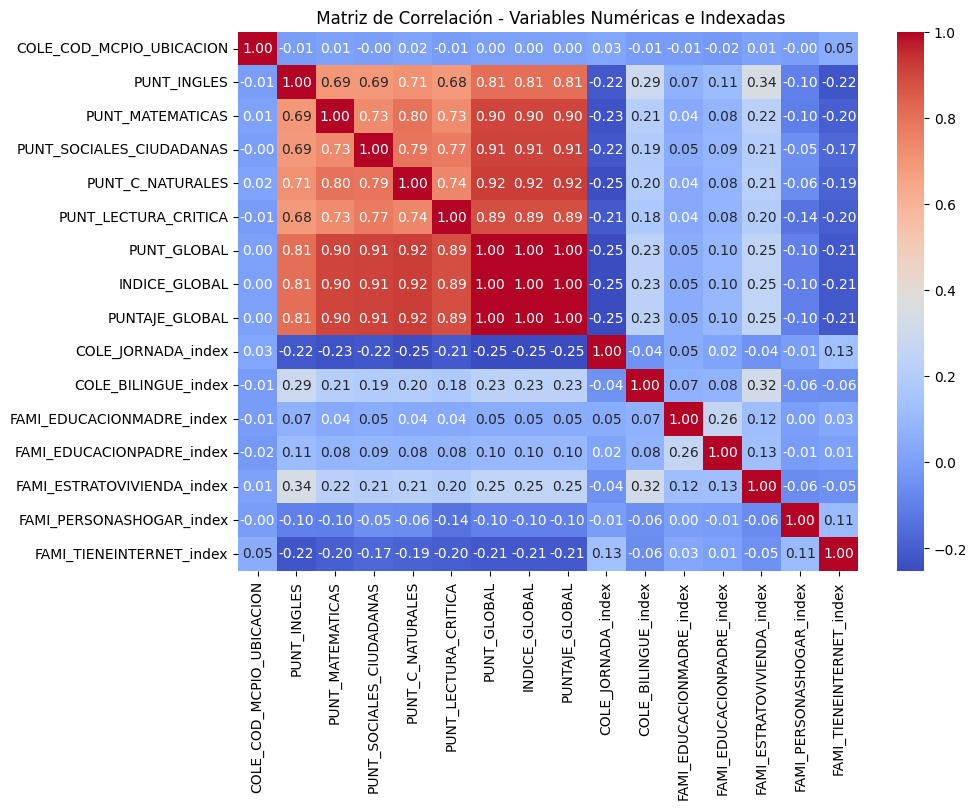

In [10]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.stat import Correlation
import pandas as pd
import numpy as np

# Lista de columnas numéricas para calcular la correlación
columnas_numericas = [
    'COLE_COD_MCPIO_UBICACION',
    'PUNT_INGLES', 'PUNT_MATEMATICAS', 'PUNT_SOCIALES_CIUDADANAS',
    'PUNT_C_NATURALES', 'PUNT_LECTURA_CRITICA', 'PUNT_GLOBAL',
    'INDICE_GLOBAL', 'PUNTAJE_GLOBAL',
    'COLE_JORNADA_index', 'COLE_BILINGUE_index',
    'FAMI_EDUCACIONMADRE_index', 'FAMI_EDUCACIONPADRE_index',
    'FAMI_ESTRATOVIVIENDA_index', 'FAMI_PERSONASHOGAR_index',
    'FAMI_TIENEINTERNET_index'
]

# Crear un vector de características
assembler = VectorAssembler(inputCols=columnas_numericas, outputCol="features_corr")
df_vectores = assembler.transform(df_icfes_filtrado).select("features_corr")

# Calcular la matriz de correlación
correlacion = Correlation.corr(df_vectores, "features_corr", "pearson").head()[0]

# Convertir a matriz numpy
matriz_corr = correlacion.toArray()

# Crear DataFrame de Pandas para visualización
df_corr = pd.DataFrame(matriz_corr, columns=columnas_numericas, index=columnas_numericas)

# Mostrar
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 7))
sns.heatmap(df_corr, annot=True, fmt=".2f", cmap="coolwarm")
plt.title(" Matriz de Correlación - Variables Numéricas e Indexadas")
plt.show()


In [11]:
# Eliminar los puntajes individuales
columnas_puntajes = [
    "PUNT_INGLES",
    "PUNT_MATEMATICAS",
    "PUNT_SOCIALES_CIUDADANAS",
    "PUNT_C_NATURALES",
    "PUNT_LECTURA_CRITICA"]

df_icfes_filtrado = df_icfes_filtrado.drop(*columnas_puntajes)

In [12]:
# Se muestra el dataset con las columnas filtradas
df_clustering=df_icfes_filtrado
df_icfes_filtrado.drop(*columnas_string).show()

+-------+------------------------+-----------+-----------------+------------------+------------------+-------------------+-------------------------+-------------------------+--------------------------+------------------------+------------------------+
|PERIODO|COLE_COD_MCPIO_UBICACION|PUNT_GLOBAL|    INDICE_GLOBAL|    PUNTAJE_GLOBAL|COLE_JORNADA_index|COLE_BILINGUE_index|FAMI_EDUCACIONMADRE_index|FAMI_EDUCACIONPADRE_index|FAMI_ESTRATOVIVIENDA_index|FAMI_PERSONASHOGAR_index|FAMI_TIENEINTERNET_index|
+-------+------------------------+-----------+-----------------+------------------+------------------+-------------------+-------------------------+-------------------------+--------------------------+------------------------+------------------------+
|  20224|                   63001|        214|42.84615384615385|214.23076923076923|               0.0|                0.0|                      2.0|                     11.0|                       0.0|                     0.0|                  

In [ ]:
cat_cols = [
    "COLE_JORNADA", "COLE_BILINGUE", "FAMI_EDUCACIONMADRE",
    "FAMI_EDUCACIONPADRE", "FAMI_ESTRATOVIVIENDA", "FAMI_PERSONASHOGAR",
    "FAMI_TIENEINTERNET"
]
df_icfes_filtrado = df_icfes_filtrado.drop(*cat_cols)

In [ ]:
df_icfes_filtrado.show(10)

+-------+------------------------+-----------+-----------------+------------------+------------------+-------------------+-------------------------+-------------------------+--------------------------+------------------------+------------------------+
|PERIODO|COLE_COD_MCPIO_UBICACION|PUNT_GLOBAL|    INDICE_GLOBAL|    PUNTAJE_GLOBAL|COLE_JORNADA_index|COLE_BILINGUE_index|FAMI_EDUCACIONMADRE_index|FAMI_EDUCACIONPADRE_index|FAMI_ESTRATOVIVIENDA_index|FAMI_PERSONASHOGAR_index|FAMI_TIENEINTERNET_index|
+-------+------------------------+-----------+-----------------+------------------+------------------+-------------------+-------------------------+-------------------------+--------------------------+------------------------+------------------------+
|  20224|                   63001|        214|42.84615384615385|214.23076923076923|               0.0|                0.0|                      2.0|                     11.0|                       0.0|                     0.0|                  

##Modelo Supervisados

In [13]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression, DecisionTreeRegressor, RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator

# 1. Seleccionar columnas indexadas para ensamblar las features
columnas_indexadas = [col + "_index" for col in columnas_string]  # columnas_string es la lista que usaste antes
columnas_numericas = ["PERIODO", "COLE_COD_MCPIO_UBICACION"]  # Puedes añadir más si tienes
input_features = columnas_indexadas + columnas_numericas

# 2. Ensamblar el vector de características
assembler = VectorAssembler(inputCols=input_features, outputCol="features")
df_modelo = assembler.transform(df_icfes_filtrado).select("features", "PUNT_GLOBAL")

# 3. Dividir los datos en entrenamiento y prueba
train_data, test_data = df_modelo.randomSplit([0.8, 0.2], seed=42)

# 4. Entrenar modelos

# a) Regresión lineal
lr = LinearRegression(featuresCol="features", labelCol="PUNT_GLOBAL")
lr_model = lr.fit(train_data)

# b) Árbol de decisión
dt = DecisionTreeRegressor(featuresCol="features", labelCol="PUNT_GLOBAL")
dt_model = dt.fit(train_data)

# c) Random Forest
rf = RandomForestRegressor(featuresCol="features", labelCol="PUNT_GLOBAL", numTrees=50)
rf_model = rf.fit(train_data)

# 5. Evaluación
evaluator = RegressionEvaluator(labelCol="PUNT_GLOBAL", predictionCol="prediction", metricName="rmse")

for name, model in [("Regresión Lineal", lr_model), ("Árbol de Decisión", dt_model), ("Random Forest", rf_model)]:
    predictions = model.transform(test_data)
    rmse = evaluator.evaluate(predictions)
    r2 = RegressionEvaluator(labelCol="PUNT_GLOBAL", predictionCol="prediction", metricName="r2").evaluate(predictions)
    print(f"\n Modelo: {name}")
    print(f"RMSE: {rmse:.2f}")
    print(f"R²:   {r2:.4f}")



 Modelo: Regresión Lineal
RMSE: 45.62
R²:   0.1809

 Modelo: Árbol de Decisión
RMSE: 40.89
R²:   0.3419

 Modelo: Random Forest
RMSE: 40.67
R²:   0.3487


andom Forest (Optimizado) y  Gradient Boosting (XGBoost-like)

In [ ]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import RandomForestRegressor, GBTRegressor  # GBTRegressor es similar a XGBoost en Spark
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

# 1. Ensamblar características (usando tus variables originales)
input_features = columnas_indexadas + columnas_numericas
assembler = VectorAssembler(inputCols=input_features, outputCol="features")
df_modelo = assembler.transform(df_icfes_filtrado).select("features", "PUNT_GLOBAL")

# 2. Dividir datos (80% entrenamiento, 20% prueba)
train_data, test_data = df_modelo.randomSplit([0.8, 0.2], seed=42)

# 3. Definir modelos y ajuste hiperparámetros

# a) Random Forest (Optimizado)
rf = RandomForestRegressor(featuresCol="features", labelCol="PUNT_GLOBAL")

# Cuadrícula de hiperparámetros para búsqueda
param_grid_rf = (ParamGridBuilder()
    .addGrid(rf.numTrees, [50, 100])  # Más árboles pueden mejorar precisión (pero más costo computacional)
    .addGrid(rf.maxDepth, [5, 10])    # Profundidad del árbol
    .build())

# b) Gradient Boosting (GBTRegressor es el equivalente a XGBoost en Spark)
gbt = GBTRegressor(featuresCol="features", labelCol="PUNT_GLOBAL")

param_grid_gbt = (ParamGridBuilder()
    .addGrid(gbt.maxIter, [50, 100])  # Número de iteraciones (árboles)
    .addGrid(gbt.maxDepth, [3, 5])    # Profundidad más baja para evitar overfitting
    .build())

# 4. Evaluador común (RMSE y R²)
evaluator = RegressionEvaluator(labelCol="PUNT_GLOBAL", predictionCol="prediction", metricName="rmse")

# 5. Validación Cruzada para ambos modelos
crossval_rf = CrossValidator(estimator=rf, estimatorParamMaps=param_grid_rf, evaluator=evaluator, numFolds=3)
crossval_gbt = CrossValidator(estimator=gbt, estimatorParamMaps=param_grid_gbt, evaluator=evaluator, numFolds=3)

# Entrenar modelos con CV
rf_model_cv = crossval_rf.fit(train_data)
gbt_model_cv = crossval_gbt.fit(train_data)

# 6. Evaluación en datos de prueba
models = {
    "Random Forest (Optimizado)": rf_model_cv.bestModel,
    "Gradient Boosting (XGBoost-like)": gbt_model_cv.bestModel
}

for name, model in models.items():
    predictions = model.transform(test_data)
    rmse = evaluator.evaluate(predictions)
    r2 = RegressionEvaluator(labelCol="PUNT_GLOBAL", predictionCol="prediction", metricName="r2").evaluate(predictions)
    print(f"\n Modelo: {name}")
    print(f"RMSE: {rmse:.2f}")
    print(f"R²:   {r2:.4f}")
    print(f"Hiperparámetros óptimos: {model.extractParamMap()}")

In [ ]:
evaluator_mae = RegressionEvaluator(labelCol="PUNT_GLOBAL", predictionCol="prediction", metricName="mae")
mae = evaluator_mae.evaluate(predictions)

In [ ]:
print(f"El error absoluto medio (MAE) es: {mae}")

El error absoluto medio (MAE) es: 31.84788771236122


##Modelo no supervisado

K-Means:

In [ ]:
from pyspark.ml.feature import VectorAssembler, StandardScaler

# Paso 1: Selección de columnas numéricas/indexadas (debes ajustar si tienes otras)
columnas_features = [
    'PERIODO',
    'COLE_JORNADA_index',
    'COLE_COD_MCPIO_UBICACION',
    'COLE_BILINGUE_index',
    'FAMI_EDUCACIONMADRE_index',
    'FAMI_EDUCACIONPADRE_index',
    'FAMI_ESTRATOVIVIENDA_index',
    'FAMI_PERSONASHOGAR_index',
    'FAMI_TIENEINTERNET_index',
    'PUNT_GLOBAL'
]

# Paso 2: Crear vector de características
assembler = VectorAssembler(inputCols=columnas_features, outputCol="features")
df_vectorizado = assembler.transform(df_clustering)

# Paso 3: Escalar (recomendado)
scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures", withMean=True, withStd=True)
scaler_model = scaler.fit(df_vectorizado)
df_escalado = scaler_model.transform(df_vectorizado)

In [ ]:
from pyspark.ml.clustering import KMeans

# Aplicar K-Means
kmeans = KMeans(featuresCol="scaledFeatures", k=4, seed=42)
modelo_kmeans = kmeans.fit(df_escalado)
df_kmeans_resultado = modelo_kmeans.transform(df_escalado)

# Mostrar resultados
df_kmeans_resultado.select("PUNT_GLOBAL", "prediction").show(10)

# Opcional: Mostrar centros de clústeres
print("Centros de clústeres:")
for i, centro in enumerate(modelo_kmeans.clusterCenters()):
    print(f"Cluster {i}: {centro}")

+-----------+----------+
|PUNT_GLOBAL|prediction|
+-----------+----------+
|        214|         2|
|        317|         0|
|        307|         0|
|        282|         0|
|        282|         0|
|        236|         2|
|        184|         0|
|        256|         3|
|        294|         0|
|        294|         0|
+-----------+----------+
only showing top 10 rows

Centros de clústeres:
Cluster 0: [ 0.01640323 -0.07697945  0.01132586 -0.15042072 -0.57911755 -0.57037326
 -0.26207801 -0.02416064 -0.42433768 -0.0775385 ]
Cluster 1: [ 0.1253884  -0.27995383 -0.09421694  1.46966546  0.34349918  0.40357684
  2.1528374  -0.32052782 -0.39697607  1.26865454]
Cluster 2: [ 0.08643214  0.04550723 -0.0467362  -0.15045604  0.7710401   0.76534022
 -0.19839384  0.00871802 -0.42327968 -0.01582865]
Cluster 3: [-0.29413802  0.31792     0.11363248 -0.14932523  0.0624489   0.01005875
 -0.13408855  0.25293859  2.35658884 -0.50927593]


In [ ]:
from pyspark.ml.evaluation import ClusteringEvaluator

# Evaluador usando la métrica de silueta con distancia euclidiana
evaluator = ClusteringEvaluator(featuresCol="scaledFeatures", predictionCol="prediction", metricName="silhouette", distanceMeasure="squaredEuclidean")

# Calcular la puntuación de silueta
silhouette = evaluator.evaluate(df_kmeans_resultado)

print(f" Silhouette Score para K-Means (PySpark): {silhouette:.4f}")


🔹 Silhouette Score para K-Means (PySpark): 0.2095


In [ ]:
from pyspark.sql.functions import mean, count

df_kmeans_resultado.groupBy("prediction").agg(
    mean("PUNT_GLOBAL").alias("avg_puntaje"),
    count("*").alias("n_estudiantes")
).show()

+----------+------------------+-------------+
|prediction|       avg_puntaje|n_estudiantes|
+----------+------------------+-------------+
|         1| 333.8751933450315|        76935|
|         3|244.06189046370312|       126223|
|         2| 268.8892993599373|       244976|
|         0| 265.8923062125332|       384674|
+----------+------------------+-------------+



Gaussian Mixture Models (GMM)

In [ ]:
from pyspark.ml.clustering import GaussianMixture
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.sql.functions import mean, count

# 1. Definir las columnas de features (ajustadas a tu dataset)
columnas_features = [
    'PERIODO',
    'COLE_JORNADA_index',
    'COLE_COD_MCPIO_UBICACION',
    'COLE_BILINGUE_index',
    'FAMI_EDUCACIONMADRE_index',
    'FAMI_EDUCACIONPADRE_index',
    'FAMI_ESTRATOVIVIENDA_index',
    'FAMI_PERSONASHOGAR_index',
    'FAMI_TIENEINTERNET_index',
    'PUNT_GLOBAL'
]

# 2. Ensamblar features y escalar (requerido para GMM)
assembler = VectorAssembler(inputCols=columnas_features, outputCol="rawFeatures")
df_assembled = assembler.transform(df_icfes_filtrado)  # Asumo que df_icfes_filtrado es tu DataFrame

scaler = StandardScaler(inputCol="rawFeatures", outputCol="scaledFeatures")
scaler_model = scaler.fit(df_assembled)
df_scaled = scaler_model.transform(df_assembled)

# 3. Entrenar GMM con k=4 (puedes ajustar este valor)
gmm = GaussianMixture(
    featuresCol="scaledFeatures",
    k=4,  # Número de clústeres
    seed=42,
    probabilityCol="probabilities",  # Opcional: almacena probabilidades por clúster
    maxIter=100  # Aumentar iteraciones para mejor convergencia
)

modelo_gmm = gmm.fit(df_scaled)
df_resultados_gmm = modelo_gmm.transform(df_scaled)

# 4. Evaluar con Silhouette Score
evaluator = ClusteringEvaluator(featuresCol="scaledFeatures")
silhouette_gmm = evaluator.evaluate(df_resultados_gmm)
print(f"🔹 Silhouette Score (GMM): {silhouette_gmm:.4f}")

# 5. Mostrar resultados
print("\n Muestra de asignaciones de clústeres (GMM):")
df_resultados_gmm.select("PUNT_GLOBAL", "prediction").show(10)

# 6. Analizar estadísticas por clúster
print("\n Estadísticas por clúster (GMM):")
df_resultados_gmm.groupBy("prediction").agg(
    mean("PUNT_GLOBAL").alias("avg_puntaje_global"),
    mean("FAMI_ESTRATOVIVIENDA_index").alias("avg_estrato"),
    mean("COLE_BILINGUE_index").alias("avg_bilingue"),
    count("*").alias("n_estudiantes")
).orderBy("avg_puntaje_global").show()

# 7. Mostrar parámetros de las Gaussianas
print("\n Parámetros de los clústeres (GMM):")
for i in range(modelo_gmm.getK()):
    print(f"\nCluster {i}:")
    print(f" Peso: {modelo_gmm.weights[i]:.4f}")
    print(f" Media: {modelo_gmm.gaussiansDF.select('mean').collect()[i][0]}")
    print(f" Covarianza: {modelo_gmm.gaussiansDF.select('cov').collect()[i][0]}")

🔹 Silhouette Score (GMM): 0.4021

📊 Muestra de asignaciones de clústeres (GMM):
+-----------+----------+
|PUNT_GLOBAL|prediction|
+-----------+----------+
|        214|         2|
|        317|         2|
|        307|         2|
|        282|         2|
|        282|         2|
|        236|         2|
|        184|         2|
|        256|         2|
|        294|         2|
|        294|         2|
+-----------+----------+
only showing top 10 rows


📌 Estadísticas por clúster (GMM):
+----------+------------------+------------------+--------------------+-------------+
|prediction|avg_puntaje_global|       avg_estrato|        avg_bilingue|n_estudiantes|
+----------+------------------+------------------+--------------------+-------------+
|         0|244.65812871746806| 0.863530050719623|0.006885254517900786|       114157|
|         2| 263.1773048340814|1.1101464204252813|                 0.0|        54364|
|         1|272.58498417971106|1.0075807484249302|                 0.0|       6

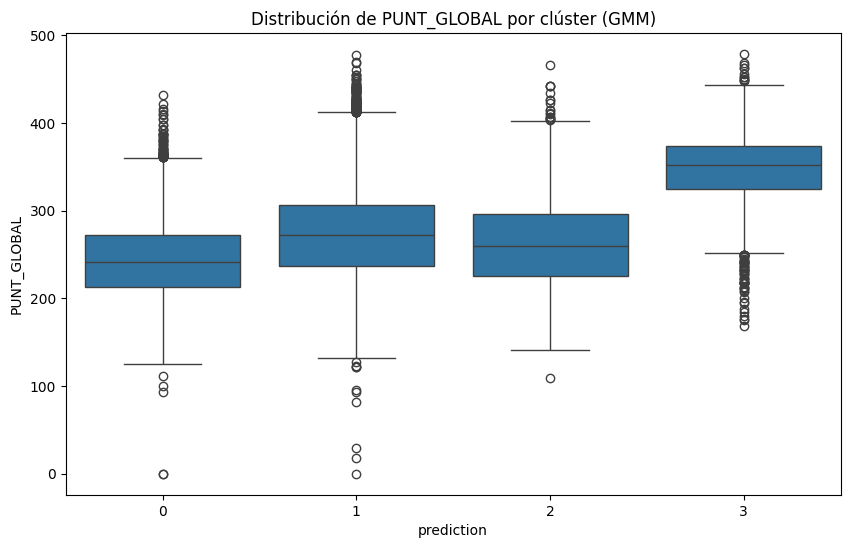

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Convertir a Pandas (muestra aleatoria si el dataset es grande)
df_pd = df_resultados_gmm.sample(0.1).select("PUNT_GLOBAL", "prediction").toPandas()

# Boxplot por clúster
plt.figure(figsize=(10, 6))
sns.boxplot(x="prediction", y="PUNT_GLOBAL", data=df_pd)
plt.title("Distribución de PUNT_GLOBAL por clúster (GMM)")
plt.show()

In [ ]:
# Métrica 1: Silhouette Score (cohesión/separación)
evaluator = ClusteringEvaluator(featuresCol="scaledFeatures")
# Use the correct DataFrame containing the GMM results
silhouette = evaluator.evaluate(df_resultados_gmm)
print(f"\n Silhouette Score: {silhouette:.4f} (Entre -1 y 1, ideal cercano a 1)")


🔷 Silhouette Score: 0.4021 (Entre -1 y 1, ideal cercano a 1)


In [ ]:
# Métrica 4: Separación entre clusters (inter-cluster distance)
def inter_cluster_distance(centers):
    from pyspark.ml.linalg import Vectors
    from itertools import combinations
    import numpy as np # Import numpy inside the function

    total_distance = 0.0
    pairs = list(combinations(centers, 2))
    for (c1, c2) in pairs:
        # Ensure centers are dense vectors or convertible
        c1_dense = Vectors.dense(c1)
        c2_dense = Vectors.dense(c2)
        total_distance += np.sqrt(Vectors.squared_distance(c1_dense, c2_dense))

    return total_distance / len(pairs)

# Get the means of the Gaussian components from the GMM model
# Extract the 'mean' column from the gaussiansDF and collect as a list of lists
centers = [row['mean'] for row in modelo_gmm.gaussiansDF.select('mean').collect()]

avg_inter_distance = inter_cluster_distance(centers)
print(f" Distancia promedio entre clusters: {avg_inter_distance:.4f} (Mayor es mejor)")

🔷 Distancia promedio entre clusters: 5.7979 (Mayor es mejor)


In [ ]:
# Métrica 5: Análisis de estabilidad (comparación con diferentes semillas)
print("\n Análisis de estabilidad con diferentes semillas:")
for seed in [42, 123, 456]:
    gmm_seed = GaussianMixture(featuresCol="scaledFeatures", k=4, seed=seed)
    model_seed = gmm_seed.fit(df_scaled)
    ll = model_seed.summary.logLikelihood
    print(f"  - Seed {seed}: Log-Likelihood = {ll:.2f}")



🔍 Análisis de estabilidad con diferentes semillas:
  - Seed 42: Log-Likelihood = -5637004.94
  - Seed 123: Log-Likelihood = -5637004.94
  - Seed 456: Log-Likelihood = -5637004.94
